In [1]:
# Import some libraries
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, os
from fredapi import Fred
from bls import get_series

In [2]:
# load dot env
from dotenv import load_dotenv
load_dotenv()

# Configure FRED and BLS API keys
API_KEY = os.getenv('FRED_API_KEY')
# os.environ['BLS_API_KEY'] = os.getenv('BLS_API_KEY')

# Initialize FRED API
fred = Fred(api_key=API_KEY)

In [56]:
from util import configure_plot

def plot_series(series_dict, title, legend_text_generator, from_date='2000-01-01', x_label='Date', y_label='Series Value', change_in=False, plot_type=sns.lineplot, legend_loc='upper right'):
    """
    Fetches and plots multiple FRED or BLS series on the same graph.
    
    Parameters:
    - series_dict: Dictionary where keys are series IDs and values are the source ('FRED' or 'BLS')
    - title: The title of the plot
    - legend_text_generator: A list that provides custom text for the legend for each series
    - from_date: The starting date for the series (default is '2000-01-01')
    - x_label: The label for the x-axis (default is 'Date')
    - y_label: The label for the y-axis (default is 'Series Value')
    """
    # Initialize an empty DataFrame for merging
    merged_df = pd.DataFrame()

    # Fetch each series based on its source (FRED or BLS) and merge into the DataFrame
    for idx, (series_id, source) in enumerate(series_dict.items()):
        if source == 'FRED':
            try:
                data = fred.get_series(series_id)
            except Exception as e:
                raise ValueError(f"Error fetching FRED series {series_id}: {e}")
        elif source == 'BLS':
            try:
                unformatted_data = get_series(series_id)  # Assuming get_series fetches BLS data

                # Convert the BLS data into a format similar to FRED (pandas Series with Date as index)
                x = unformatted_data.index.to_timestamp()
                y = unformatted_data.values
                data = pd.Series(y, index=x)
            except Exception as e:
                raise ValueError(f"Error fetching BLS series {series_id}: {e}")
        else:
            raise ValueError(f"Invalid source '{source}' for series {series_id}. Use 'FRED' or 'BLS'.")

        # Create DataFrame from the fetched data
        df = pd.DataFrame(data, columns=[f"Value_{idx}"])
        df['Date'] = df.index
        df = df[df['Date'] >= from_date]  # Filter from the specified date onwards

        # Merge with the main DataFrame on 'Date'
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

    # If change_in is True, calculate the change in value for each series
    if change_in:
        for idx in range(len(series_dict)):
            merged_df[f'Value_{idx}'] = merged_df[f'Value_{idx}'].diff()

    # Set up the style using seaborn
    sns.set(style="whitegrid", palette="dark")

    # Create a figure and axis with a larger size for better aesthetics
    plt.figure(figsize=(12, 8))

    # Plot each series
    for idx in range(len(series_dict)):
        plot_type(x='Date', y=f'Value_{idx}', data=merged_df, 
                     label=legend_text_generator[idx], linewidth=2)

    # Enhance the title and labels
    plt.title(title, fontsize=18, weight='bold', color='#333333')
    plt.xlabel(x_label, fontsize=14, weight='bold', color='#333333')
    plt.ylabel(y_label, fontsize=14, weight='bold', color='#333333')

    # Rotate the x-axis labels for better readability and adjust their size
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add a grid with more customization
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    # Show the legend with a custom location and background
    plt.legend(loc=legend_loc, frameon=True, fontsize=12, fancybox=True, shadow=True)

    # Check which source it has
    if 'FRED' in series_dict.values() and 'BLS' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.27, 0, 'Source: Federal Reserve Economic Data and U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    elif 'FRED' in series_dict.values():
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: Federal Reserve Economic Data', ha="center", fontsize=12, style='italic')
    else:
        # Add a footer with the source of the data
        plt.figtext(0.17, 0, 'Source: U.S. Bureau of Labor Statistics', ha="center", fontsize=12, style='italic')
    
        
    # Tighten layout to make the plot look cleaner
    plt.tight_layout()

    # Display the plot
    plt.show()


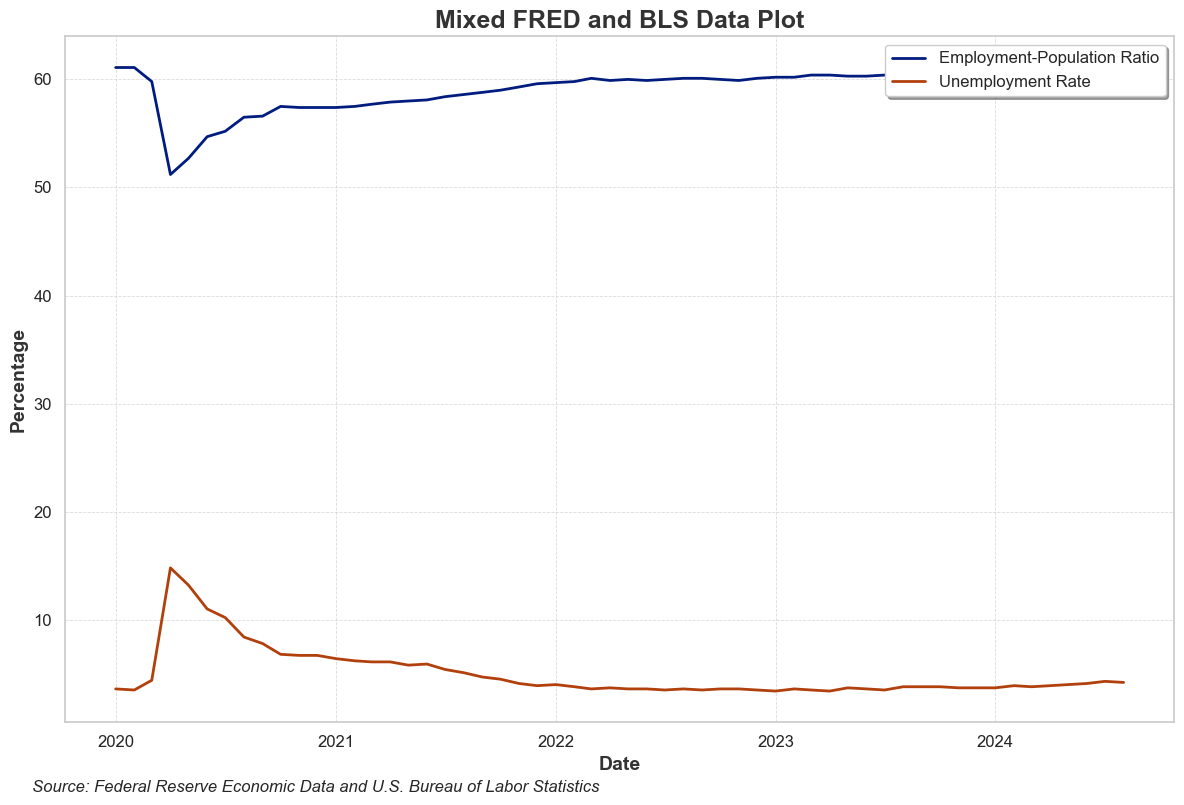

In [42]:
# Define the series IDs and their sources
# Define the series IDs and their sources
series_dict = {
    'EMRATIO': 'FRED',       # Civilian Employment-Population Ratio (FRED, Percentage)
    'LNS14000000': 'BLS'     # Unemployment Rate (BLS, Percentage)
}

legend = ['Employment-Population Ratio', 'Unemployment Rate']

# Call the function with your custom inputs
plot_series(series_dict, 'Mixed FRED and BLS Data Plot', legend, from_date='2020-01-01', y_label='Percentage')

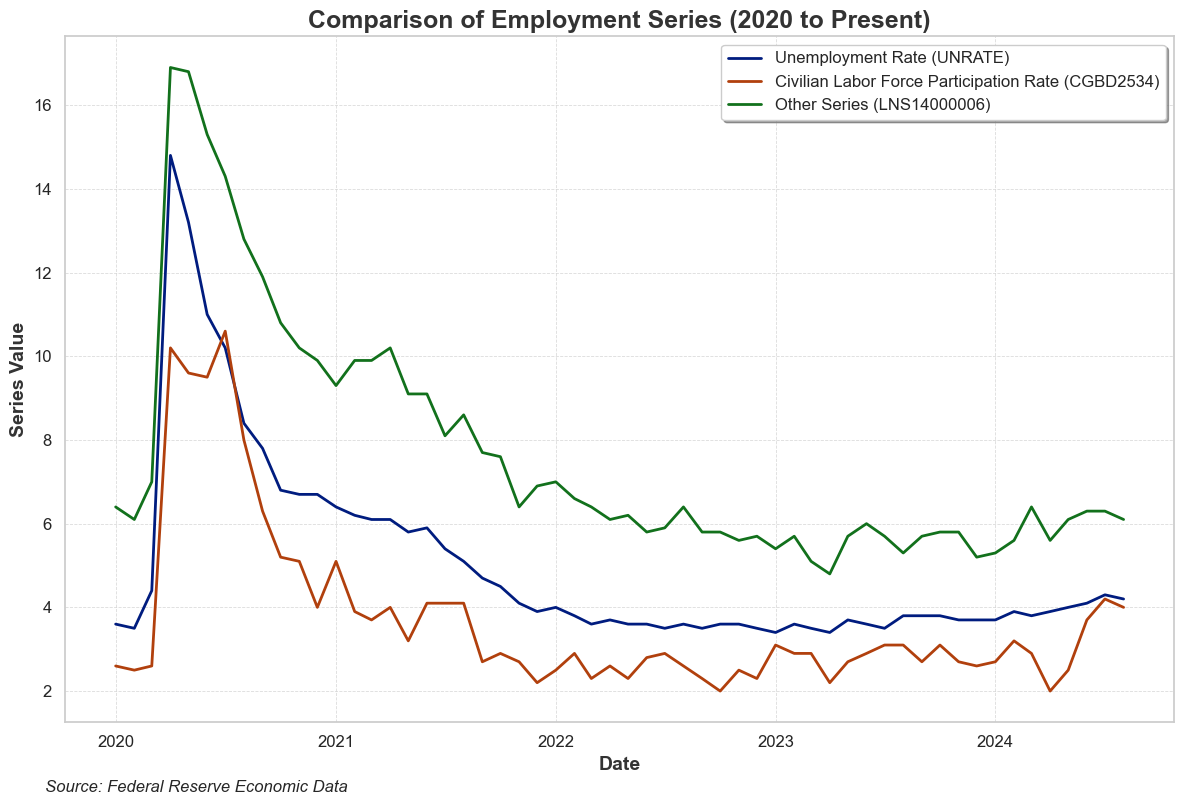

In [52]:
# Define the series IDs you want to plot
series_ids = {
    'UNRATE': 'FRED',
    'CGBD2534': 'FRED',
    'LNS14000006': 'FRED'
}

legend = [
    "Unemployment Rate (UNRATE)",
    "Civilian Labor Force Participation Rate (CGBD2534)",
    "Other Series (LNS14000006)"
]

# Call the function with your custom inputs
plot_series(series_ids, 
                 title="Comparison of Employment Series (2020 to Present)", 
                 legend_text_generator=legend,
                 from_date='2020-01-01')


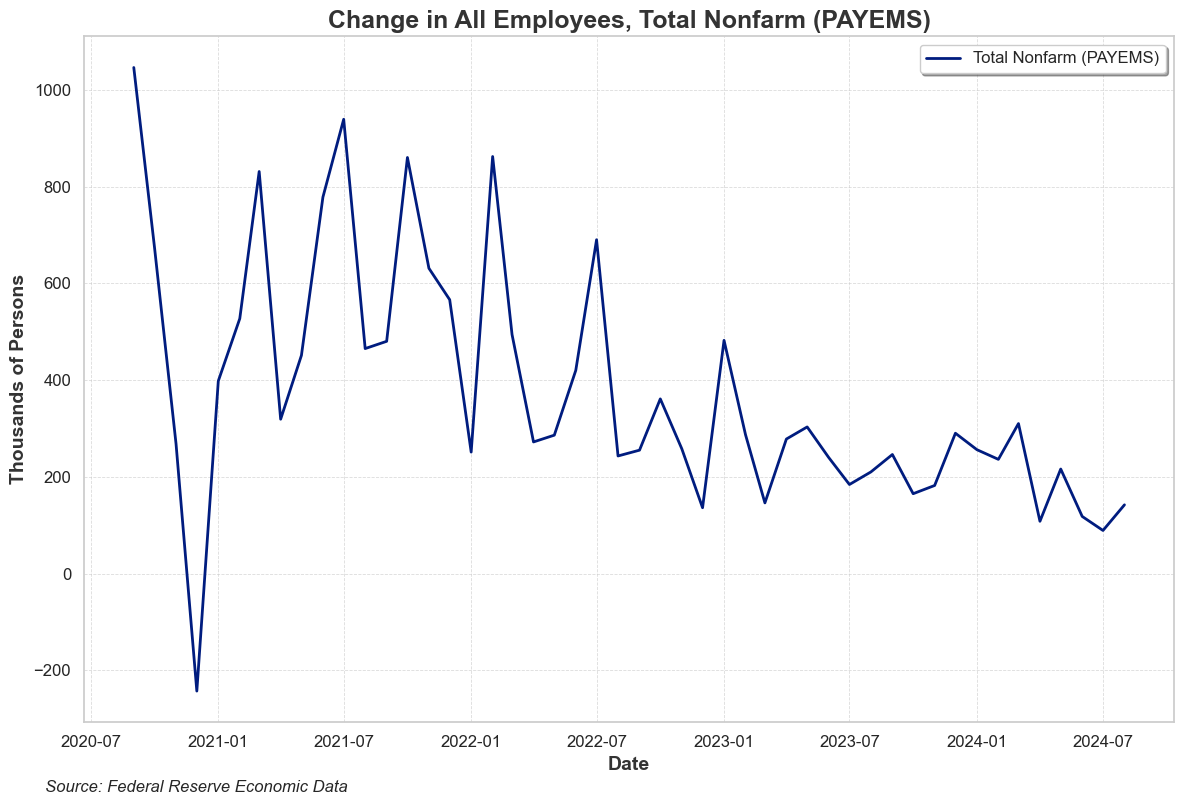

In [53]:
# Define the series IDs you want to plot
series_ids = {'PAYEMS': 'FRED',}

legend = ["Total Nonfarm (PAYEMS)",]

# Call the function with your custom inputs
plot_series(series_ids, 
                 title="Change in All Employees, Total Nonfarm (PAYEMS)", 
                 y_label='Thousands of Persons',
                 legend_text_generator=legend,
                 from_date='2020-08-01',
                 change_in=True)


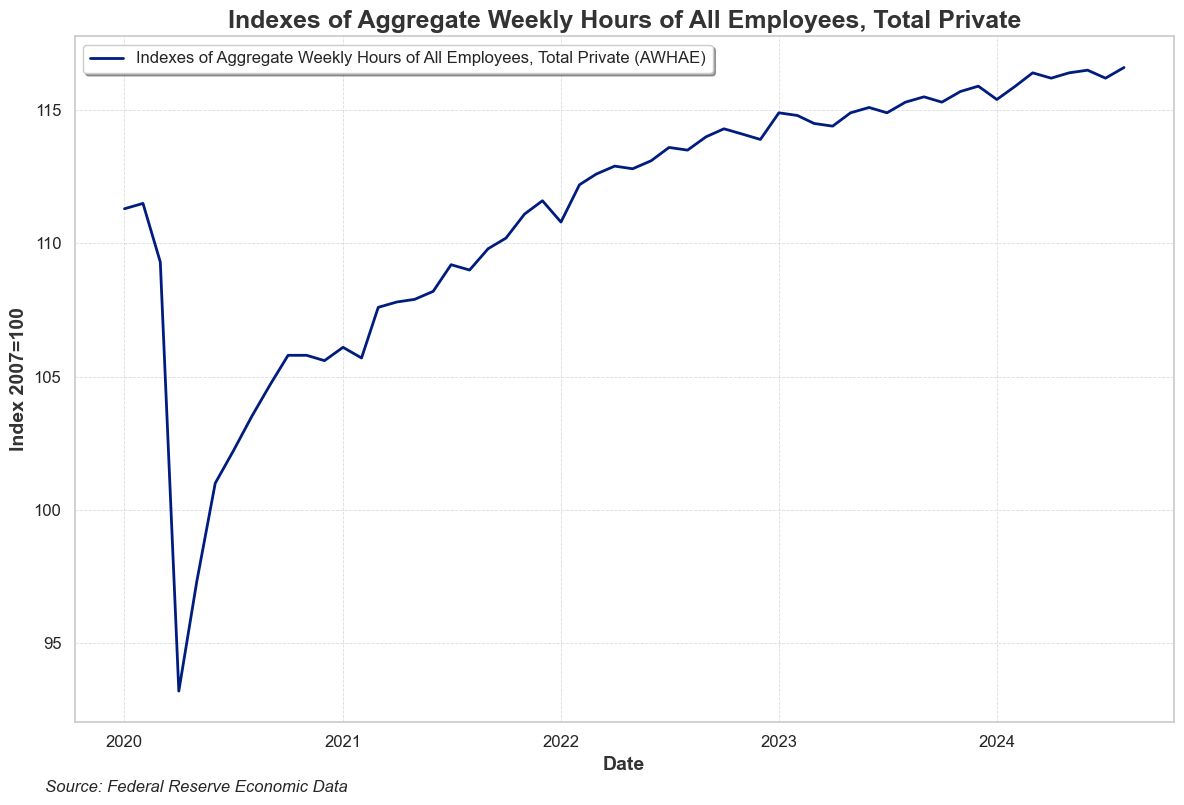

In [60]:
# Define the series IDs you want to plot
series_ids = {'AWHAE': 'FRED',}

legend = ["Indexes of Aggregate Weekly Hours of All Employees, Total Private (AWHAE)",]

# Call the function with your custom inputs
plot_series(series_ids, 
                 title="Indexes of Aggregate Weekly Hours of All Employees, Total Private", 
                 y_label='Index 2007=100',
                 legend_text_generator=legend,
                 from_date='2020-01-01',
                 legend_loc='upper left')


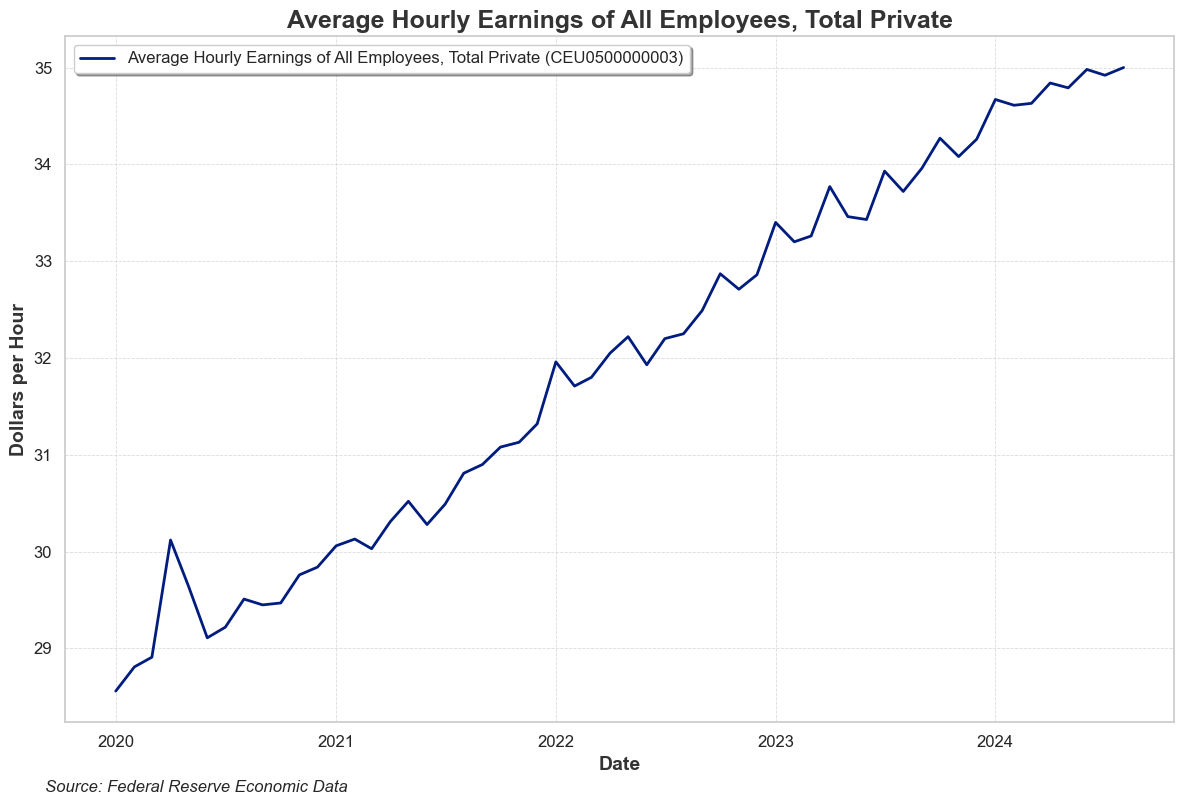

In [63]:
# Define the series IDs you want to plot
series_ids = {'CEU0500000003': 'FRED',}

legend = ["Average Hourly Earnings of All Employees, Total Private (CEU0500000003)",]

# Call the function with your custom inputs
plot_series(series_ids, 
                 title="Average Hourly Earnings of All Employees, Total Private", 
                 y_label='Dollars per Hour',
                 legend_text_generator=legend,
                 from_date='2020-01-01',
                 legend_loc='upper left',)


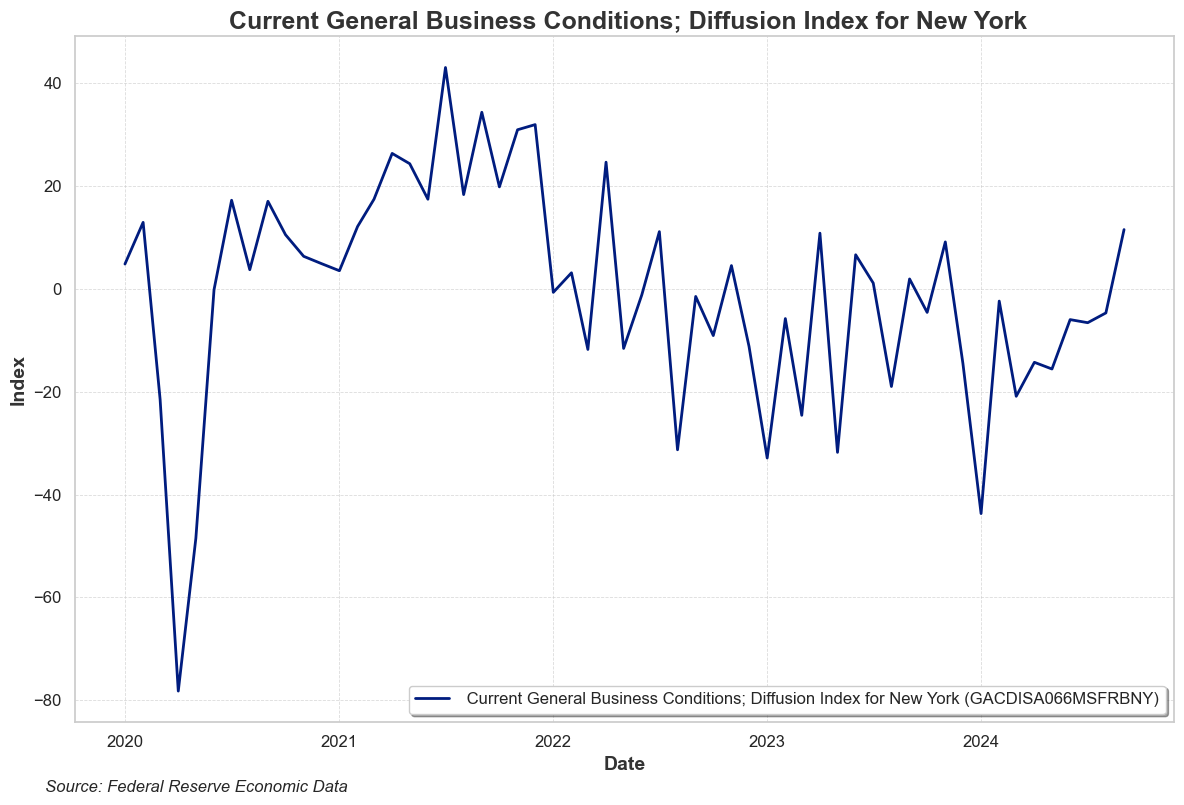

In [65]:
# Define the series IDs you want to plot
series_ids = {'GACDISA066MSFRBNY': 'FRED',}

legend = [" Current General Business Conditions; Diffusion Index for New York (GACDISA066MSFRBNY)",]

# Call the function with your custom inputs
plot_series(series_ids, 
                 title=" Current General Business Conditions; Diffusion Index for New York", 
                 y_label='Index',
                 legend_text_generator=legend,
                 from_date='2020-01-01',
                 legend_loc='lower right',)
